# HarvardX_MITx_Person_Course_Dataset_EDA_Intended

Based on the EDA of registered, we concluded that most of those who registered in a MOOC course did not meant to complete it. Talking about completion rate of registered does not make sense. We do need to take the learners' intention into consideration when exploring the completion rate.

In this notebook file, we will first define intended, which is our target subpopulation. Then we do EDA(exploratory data analysis) on the subset of intended.  


## Loading dataset of registered

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import datetime
from scipy.stats import chisquare
from scipy.stats import ttest_ind 
from scipy.stats import binom_test

%matplotlib inline

In [2]:
# load data
df_registered = pd.read_csv('hmx_eda.csv', parse_dates=['time_registered', 'last_event', 'course_launch', 'course_wrap'])
df_registered.head()

,course_id,user_id,viewed,explored,certified,country,education,gender,grade,time_registered,...,nforum_posts,institution,course_code,semester,age,course_launch,course_wrap,course_duration,registered_launch_delta,lifetime_proportion
0,HarvardX/CS50x/2012,MHxPC130422039,0,0,0,Unknown/Other,Secondary,m,0.0,2012-07-24,...,0,HarvardX,CS50x,2012_Fall,25.0,2012-10-15,2013-04-15,182,-83,0.000000
1,HarvardX/CS50x/2012,MHxPC130407931,0,0,0,United States,Secondary,f,0.0,2012-07-24,...,0,HarvardX,CS50x,2012_Fall,44.0,2012-10-15,2013-04-15,182,-83,0.000000
2,HarvardX/PH207x/2012_Fall,MHxPC130313697,0,0,0,India,Bachelor's,m,0.0,2012-07-24,...,0,HarvardX,PH207x,2012_Fall,23.0,2012-10-15,2013-01-30,107,-83,266.355140
3,HarvardX/CS50x/2012,MHxPC130064950,0,0,0,Unknown/Other,Master's,m,0.0,2012-07-24,...,0,HarvardX,CS50x,2012_Fall,34.0,2012-10-15,2013-04-15,182,-83,0.000000
4,HarvardX/PH207x/2012_Fall,MHxPC130237753,1,0,0,United States,Secondary,m,0.0,2012-07-24,...,0,HarvardX,PH207x,2012_Fall,19.0,2012-10-15,2013-01-30,107,-83,65.420561


In [3]:
# size of the dataset
print('The registered dataset has {} records with {} columns'.format(df_registered.shape[0], df_registered.shape[1]))

The registered dataset has 402750 records with 25 columns


## Define Intended

We totally agree that the learners in MOOC are behaving differently from the traditional education learners. Some registered just to bookmark a course and most of them never come back; Some prospective college students registered to decide which major to take; Some registered to audit the course, did not mean to complete the course. However, we argue that there are still some students who intended to complete the course. Their behavior is similar to that of the traditional education. This subpopulation is our target population of research. We will define intended below to explore their retention pattern. The intended is defined as those who intended to complete a course.

As we know, in traditional on-campus courses, there are 2 weeks that the students can audit the course to decide whether to take the course or not. 2 weeks is roughly 13% of a semester long course. Similarly we will use 13% proportion to filter the intended.

However, this 13% proportion alone may not be enough. To define intended, we will also make sure a learner interacted with the course during his lifetime. We will also use 13% of chapters viewed to fiter the intended.

There are some learners who interacted a lot with the course but did not meant to complete the course. We assume that these learners are less likely to do the quizzes and assignments thus their grade may be pretty low. To exclude them from our subset, we will make sure all the intended have a grade greater than 0.

Based on the above, we will use these 3 conditions to filter the intended:

- The learner's lifetime is more than 13% of the course duration
- The learner interacted with at least 13% of the chapters.
- The learner's grade is more than 0.

In order to get our subset, first we need to do some feature engineering.

We have the number of chapters the learner viewed, but we do not have the number of chapters in the course. We assume that for each course at least one learner who certified view all the chapters. We will regard the max of nchapters as the number of chapters of the course. Then we will calcuate the proportion of chapters viewed in chapters of the course.


In [4]:
# create a dictionary with the course_id as the key, the max of nchapters as the value
nchapters_dic_key = df_registered.groupby('course_id').nchapters.max().index
nchapters_dic_value = df_registered.groupby('course_id').nchapters.max().values
nchapters_dic = dict(zip(nchapters_dic_key, nchapters_dic_value))


In [5]:
# map the dictionary to create a new column course_chapters, then create chapters_proportion variable.
df_registered['course_chapters'] = df_registered['course_id'].map(nchapters_dic)
df_registered['chapters_proportion'] = 100*df_registered['nchapters'] / df_registered['course_chapters']


In [6]:
# create intended variable based on the 2 conditions: lifetime_proportion > 13% and chapters_proportion > 13%

intended_condition =  (df_registered['lifetime_proportion'] > 13) & (df_registered['chapters_proportion'] > 13) & (df_registered['grade'] > 0) 
df= df_registered[intended_condition] 
df.head()

,course_id,user_id,viewed,explored,certified,country,education,gender,grade,time_registered,...,course_code,semester,age,course_launch,course_wrap,course_duration,registered_launch_delta,lifetime_proportion,course_chapters,chapters_proportion
30,HarvardX/CS50x/2012,MHxPC130320562,1,1,1,Other Europe,Master's,m,1.00,2012-07-24,...,CS50x,2012_Fall,29.0,2012-10-15,2013-04-15,182,-83,111.538462,12.0,100.00
61,HarvardX/PH207x/2012_Fall,MHxPC130123976,1,1,0,Other Europe,Master's,f,0.29,2012-07-24,...,PH207x,2012_Fall,29.0,2012-10-15,2013-01-30,107,-83,267.289720,16.0,56.25
116,HarvardX/ER22x/2013_Spring,MHxPC130076788,1,1,0,Other South Asia,Secondary,m,0.30,2012-12-20,...,ER22x,2013_Spring,18.0,2013-03-02,2013-07-26,146,-72,102.054795,34.0,50.00
158,HarvardX/CS50x/2012,MHxPC130574671,1,1,1,Egypt,Secondary,m,1.00,2012-10-16,...,CS50x,2012_Fall,17.0,2012-10-15,2013-04-15,182,1,136.263736,12.0,100.00
190,HarvardX/PH207x/2012_Fall,MHxPC130118631,1,0,0,Other Europe,Master's,m,0.18,2012-07-24,...,PH207x,2012_Fall,29.0,2012-10-15,2013-01-30,107,-83,35.514019,16.0,43.75


Since our main focus is on intended, we will drop viewed and explored

In [7]:
# drop viewed and explored
df = df.drop(['viewed', 'explored'], axis=1)

In [8]:
# size of the dataset
print('The intended dataset has {} records with {} columns'.format(df.shape[0], df.shape[1]))

The intended dataset has 48278 records with 25 columns


In [9]:
# proportion of subset

print('{:.2%} of the registered intended to complete a course'.format(df.shape[0]/df_registered.shape[0]))

11.99% of the registered intended to complete a course


In [10]:
# basic info 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48278 entries, 30 to 402436
Data columns (total 25 columns):
course_id                  48278 non-null object
user_id                    48278 non-null object
certified                  48278 non-null int64
country                    48278 non-null object
education                  48278 non-null object
gender                     48278 non-null object
grade                      48278 non-null float64
time_registered            48278 non-null datetime64[ns]
last_event                 48278 non-null datetime64[ns]
nevents                    48278 non-null float64
ndays_act                  48278 non-null float64
nplay_video                48278 non-null float64
nchapters                  48278 non-null float64
nforum_posts               48278 non-null int64
institution                48278 non-null object
course_code                48278 non-null object
semester                   48278 non-null object
age                        48278 non-

In [11]:
# statistical description
df.describe()

,certified,grade,nevents,ndays_act,nplay_video,nchapters,nforum_posts,age,course_duration,registered_launch_delta,lifetime_proportion,course_chapters,chapters_proportion
count,48278.000000,48278.000000,48278.000000,48278.000000,48278.000000,48278.000000,48278.000000,48278.000000,48278.000000,48278.000000,48278.000000,48278.000000,48278.000000
mean,0.283007,0.314360,2428.193877,22.965927,256.977547,9.514914,0.080389,26.964000,114.530490,-2.258482,89.307247,19.326526,49.721685
std,0.450464,0.355073,2973.876468,21.457286,529.599820,6.997804,0.393281,8.558269,20.805053,42.516473,59.204980,6.747087,30.526096
min,0.000000,0.010000,1.000000,1.000000,0.000000,2.000000,0.000000,11.000000,71.000000,-147.000000,13.013699,11.000000,13.636364
25%,0.000000,0.020000,561.000000,8.000000,8.000000,4.000000,0.000000,21.000000,107.000000,-26.000000,38.775510,16.000000,21.052632
50%,0.000000,0.110000,1264.500000,15.000000,86.000000,7.000000,0.000000,25.000000,111.000000,-2.000000,88.785047,19.000000,38.235294
75%,1.000000,0.660000,3173.000000,32.000000,278.000000,13.000000,0.000000,30.000000,120.000000,12.000000,115.753425,19.000000,81.734007
max,1.000000,1.000000,53180.000000,162.000000,24564.000000,47.000000,6.000000,78.000000,182.000000,325.000000,339.795918,47.000000,100.000000


## Univariate EDA

First we do EDA on each variable.

###  course_id

In [12]:
# value counts of course_id
df.course_id.value_counts()

MITx/6.00x/2012_Fall           8589
MITx/6.00x/2013_Spring         7389
HarvardX/PH207x/2012_Fall      6032
MITx/14.73x/2013_Spring        4520
HarvardX/ER22x/2013_Spring     4501
MITx/6.002x/2012_Fall          3639
HarvardX/PH278x/2013_Spring    2444
MITx/7.00x/2013_Spring         2057
MITx/8.02x/2013_Spring         2000
MITx/6.002x/2013_Spring        1705
HarvardX/CB22x/2013_Spring     1263
MITx/3.091x/2012_Fall          1249
HarvardX/CS50x/2012            1060
MITx/2.01x/2013_Spring          731
MITx/8.MReV/2013_Summer         719
MITx/3.091x/2013_Spring         380
Name: course_id, dtype: int64

In [13]:
# proportion of intended by course
intended_proportion = 100*df.course_id.value_counts() / df_registered.course_id.value_counts()
intended_proportion

HarvardX/CB22x/2013_Spring      6.359517
HarvardX/CS50x/2012             1.255894
HarvardX/ER22x/2013_Spring     11.128968
HarvardX/PH207x/2012_Fall      18.653555
HarvardX/PH278x/2013_Spring     9.300910
MITx/14.73x/2013_Spring        21.689060
MITx/2.01x/2013_Spring         19.431154
MITx/3.091x/2012_Fall          12.351661
MITx/3.091x/2013_Spring        11.459590
MITx/6.002x/2012_Fall          15.329851
MITx/6.002x/2013_Spring        14.345814
MITx/6.00x/2012_Fall           16.358754
MITx/6.00x/2013_Spring         20.191283
MITx/7.00x/2013_Spring         14.397704
MITx/8.02x/2013_Spring         12.347203
MITx/8.MReV/2013_Summer        11.609882
Name: course_id, dtype: float64

In [14]:
# min count and  max count
intended_proportion.describe()

count    16.000000
mean     13.513175
std       5.298762
min       1.255894
25%      11.376935
50%      13.348738
75%      16.932454
max      21.689060
Name: course_id, dtype: float64

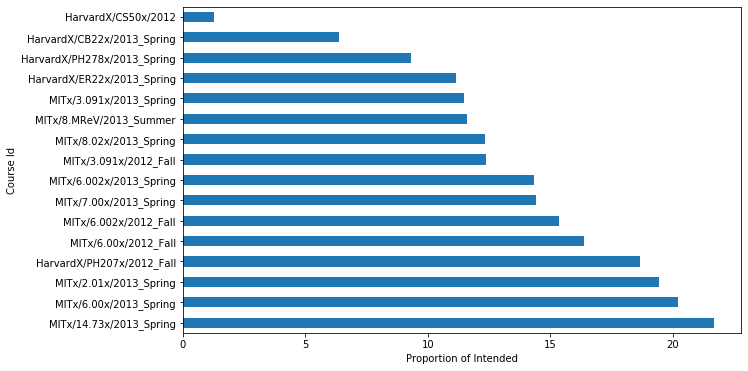

In [15]:
# bar plot of course_id
plt.figure(figsize=(10, 6))
intended_proportion.sort_values(ascending=False).plot(kind='barh')
plt.xlabel('Proportion of Intended')
plt.ylabel('Course Id');

The proportion of intended varies from course. Ranges from 1.26% to 21.69% with a mean of 13.51. The proportion of intended is less than 16.93% for most courses.

### user_id

In [16]:
# number of unique user_ids
print('There are {} unique users in the registered dataset, while {} users intended to complete the course'.format(df_registered.user_id.nunique(), df.user_id.nunique()))



There are 323419 unique users in the registered dataset, while 44751 users intended to complete the course


In [17]:
# number of courses registered
user_ncourse_df = df.groupby(['user_id']).course_id.count().reset_index()
user_ncourse_df.columns = ['user_id','ncourse']
user_ncourse_df['ncourse'].describe()

count    44751.000000
mean         1.078814
std          0.314101
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: ncourse, dtype: float64

Most learners registered in 1 course, some registered in more than one course, the max is 6.

### certified

In [18]:
# count of certified
certified_count = df[df.certified == 1].shape[0]

In [19]:
print('Among {} intended, only {} finnaly got certified, the overall certification rate is about {:.2%}'.format(df.shape[0], certified_count, (certified_count/ df.shape[0])))


Among 48278 intended, only 13663 finnaly got certified, the overall certification rate is about 28.30%


### country

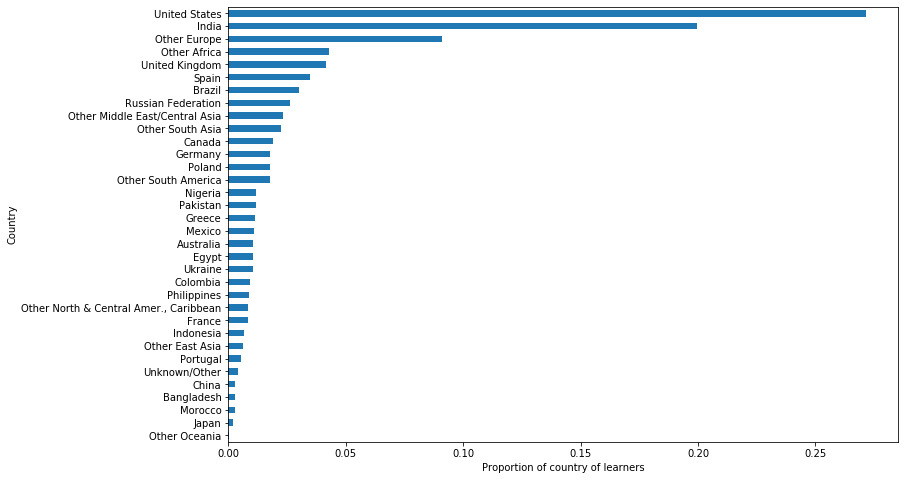

In [20]:
# country 
(df.groupby('country').user_id.count() / df.shape[0]) .sort_values().plot(figsize=(12, 8), kind='barh')
plt.xlabel('Proportion of country of learners')
plt.ylabel('Country');

Only less than 30% learners are from US. Among those from over seas, a large proportion are from India, only a small portion are from countries like China, Japan.

### education

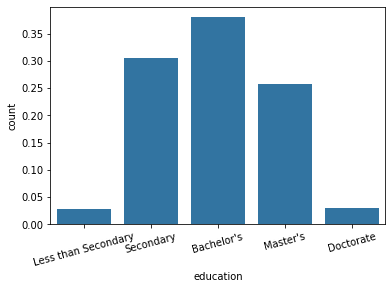

In [21]:
# Level of educatoin
n_records = df.shape[0]
max_value = df.education.value_counts().max()
max_prop = max_value / n_records
tick_props = np.arange(0, max_prop+0.01, 0.05)
tick_names = ['{:.2f}'.format(x) for x in tick_props]

base_color = sb.color_palette()[0]
order = ['Less than Secondary','Secondary', "Bachelor's", "Master's", 'Doctorate']
sb.countplot(data=df, x='education', color=base_color, order=order)
plt.xticks(rotation=15)
plt.yticks(tick_props*n_records, tick_names);

As much as 40% students hold a Bachelor's Degree, while around 25% hold a Master's, 3% hold a Doctorate Degree. That is to say, the mojority of the students have a education level of Bachelor's or higher. We are educating the well educated.

### Age

In [22]:
# statistical description
df['age'].describe()

count    48278.000000
mean        26.964000
std          8.558269
min         11.000000
25%         21.000000
50%         25.000000
75%         30.000000
max         78.000000
Name: age, dtype: float64

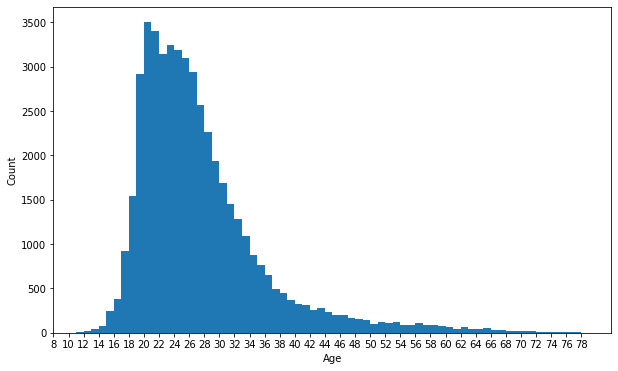

In [23]:
# distribution of age
plt.figure(figsize=(10,6))
max_age = df.age.max()
min_age = df.age.min()

bins = np.arange(0, max_age+1, 1)
ticks = np.arange(8, max_age+1, 2)
plt.hist(data=df, x='age', bins=bins)
plt.xticks(ticks)
plt.xlim(8, 82)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Most learners are in their 20s. Some young learners are as little as 11 years old. While some learners are as old as 78 years old.

### gender

In [24]:
# value counts of gender
df.gender.value_counts()

m    35142
f    13136
Name: gender, dtype: int64

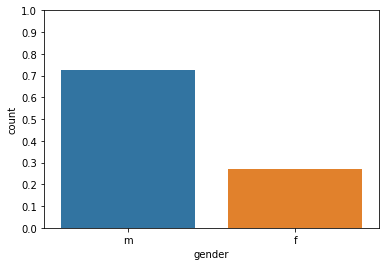

In [25]:
# bar chart of gender
sb.countplot(data=df, x='gender')
n_records = df.shape[0]
tick_props = np.arange(0, 1+0.1, 0.1)
tick_names = ['{:.1f}'.format(x) for x in tick_props]
plt.yticks(tick_props*n_records, tick_names);

More than 70% of the students are male and only less than 30% are female. We will conduct a z test and a chi square test below to see how reliable is this result.

In [26]:
# z test
from scipy.stats import binom_test
binom_test(x=df.gender.value_counts()[0], n=df.shape[0], p=0.5, alternative='greater')

0.0

The p value is 0, there is sufficient evidance that there are more male learners than female learners.

In [27]:
# chi sqaure test
from scipy.stats import chisquare
chisquare([df.gender.value_counts()[0], df.gender.value_counts()[1]], ddof=[0])

Power_divergenceResult(statistic=10030.73938439869, pvalue=array([0.]))

The p value is 0, there is sufficient evidance that the proportion of female and male are different.

### grade

'grade' is a continuous variable ranges from 0 to 1, we will plot a histogram to check the distribution of this variable.

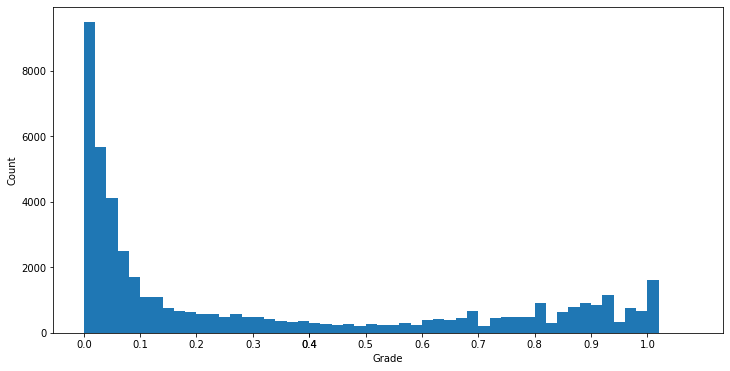

In [28]:
# distribution of grade in bin size 0.05
plt.figure(figsize=(12, 6))
ticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bins = np.arange(0, 1+0.1, 0.02)
plt.hist(data=df, x='grade', bins=bins)
plt.xlabel('Grade')
plt.ylabel('Count')
plt.xticks(ticks);

In [29]:
# statistical description
df.grade.describe()

count    48278.000000
mean         0.314360
std          0.355073
min          0.010000
25%          0.020000
50%          0.110000
75%          0.660000
max          1.000000
Name: grade, dtype: float64

Although we defined intended as the grade > 0, the average grade is still as low as 0.31 with a medium grade 0.11. The majority need some more help rather than a small nudge.

### time_registered

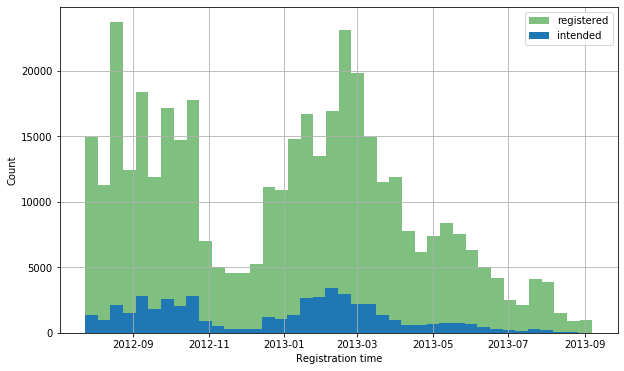

In [30]:
# distribution of time registered: intended VS registered
df_registered.time_registered.hist(figsize=(10, 6), bins=40, color='green', alpha=0.5, label='registered')
df.time_registered.hist(figsize=(10, 6), bins=40, label='intended')
plt.legend()
plt.xlabel('Registration time')
plt.ylabel('Count');

The registration trends of registered and intended  are similar.


### last_event


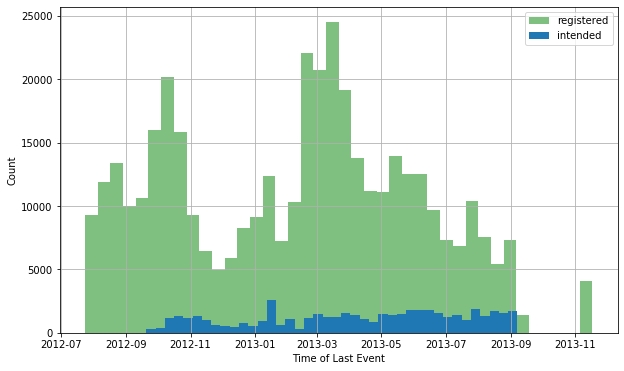

In [31]:
# distribution of last event time: intended VS registered
df_registered.last_event.hist(figsize=(10, 6), bins=40, color='green', alpha=0.5, label='registered')
df.last_event.hist(figsize=(10, 6), bins=40, label='intended')
plt.legend()
plt.xlabel('Time of Last Event')
plt.ylabel('Count');

Where there is a peak of the last event time of the registered, there  is not a significant peak observed for the intended.

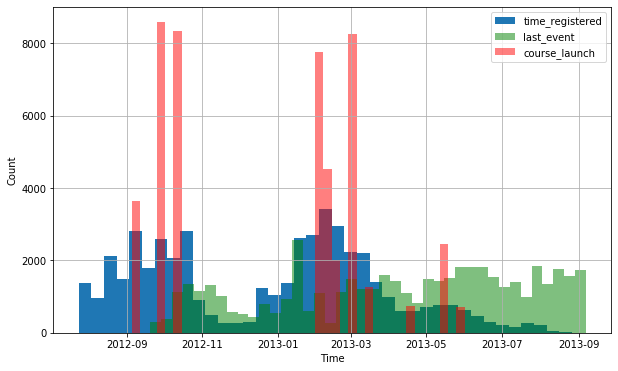

In [32]:
# distribution of time registered VS last event VS course launch
df.time_registered.hist(figsize=(10, 6), bins=40, label='time_registered')
df.last_event.hist(figsize=(10, 6), bins=40, color='green', alpha = 0.5, label='last_event')
df.course_launch.hist(figsize=(10, 6), bins=40, color='red', alpha=0.5, label='course_launch')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend()
plt.show()

### nevents, ndays_act, nplay_video, nchapters, nforum_posts: activities

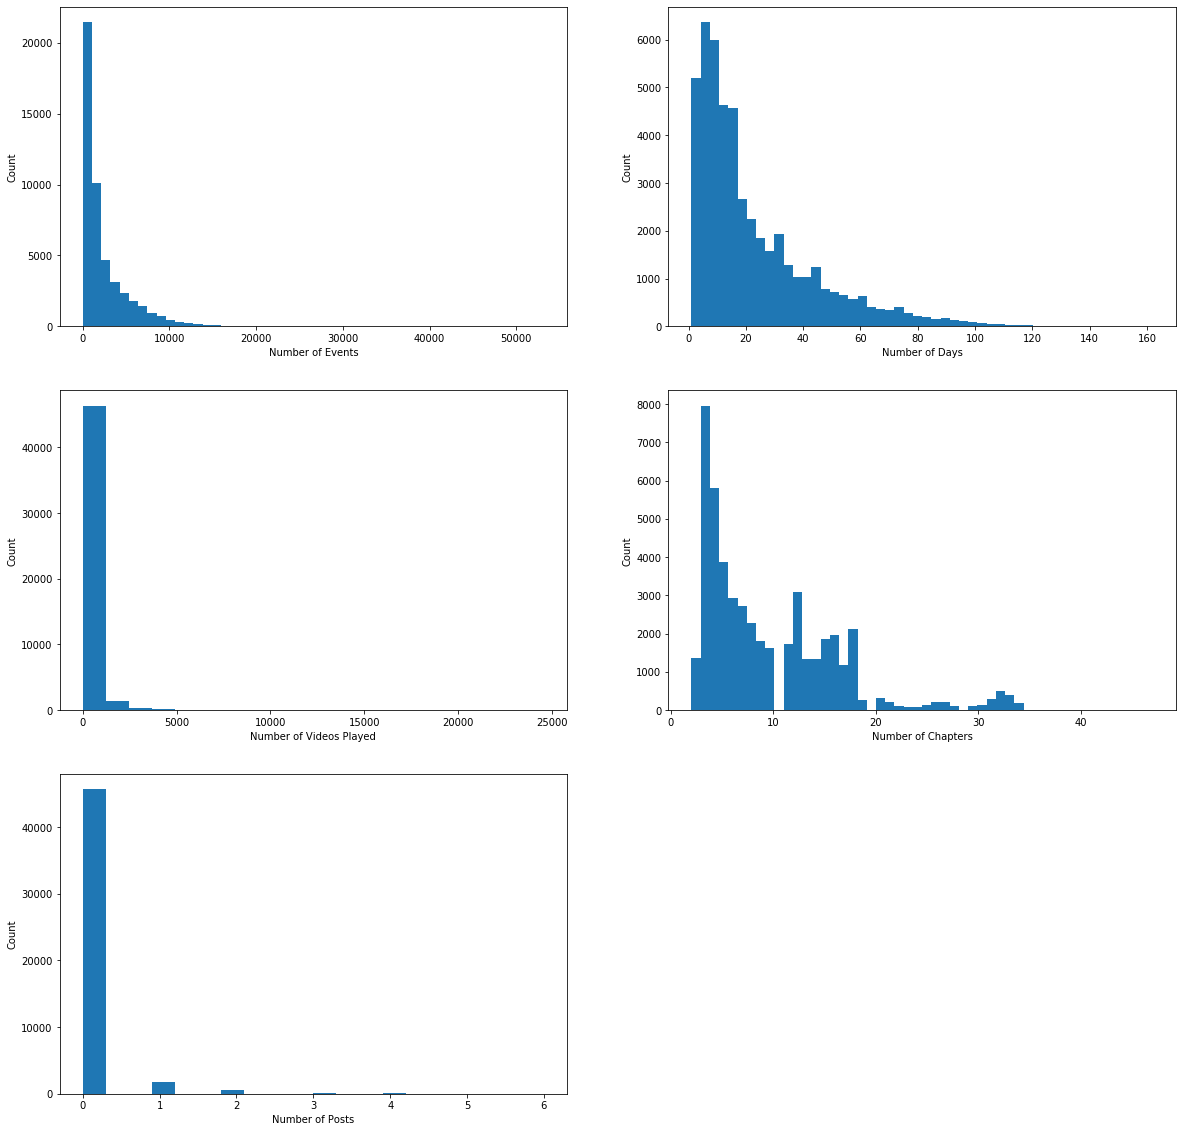

In [33]:
# distribution of nevents, ndays_act, nplay_video, nchapters, nforum_posts
plt.figure(figsize=(20,20))

plt.subplot(3, 2, 1)
plt.hist(data=df, x='nevents', bins=50)
plt.xlabel('Number of Events')
plt.ylabel('Count')

plt.subplot(3, 2, 2)
plt.hist(data=df, x='ndays_act', bins=50)
plt.xlabel('Number of Days')
plt.ylabel('Count')

plt.subplot(3, 2, 3)
plt.hist(data=df, x='nplay_video', bins=20)
plt.xlabel('Number of Videos Played')
plt.ylabel('Count')

plt.subplot(3, 2, 4)
plt.hist(data=df, x='nchapters', bins=50)
plt.xlabel('Number of Chapters')
plt.ylabel('Count')

plt.subplot(3, 2, 5)
plt.hist(data=df, x='nforum_posts', bins=20)
plt.xlabel('Number of Posts')
plt.ylabel('Count')
plt.show()

The distribution of nevents, ndays_act, nplay_video, nchapters, nforum_posts are all right skewed, many learners have a pretty small number of activities

### institution

In [34]:
# proportion of intended by institution
df.institution.value_counts() / df_registered.institution.value_counts()

HarvardX    0.075251
MITx        0.165361
Name: institution, dtype: float64

In [35]:
df.institution.value_counts()

MITx        32978
HarvardX    15300
Name: institution, dtype: int64

In [36]:
df_registered.institution.value_counts()

HarvardX    203320
MITx        199430
Name: institution, dtype: int64

### semester

In [37]:
# proportion of intended by semester
100*df.semester.value_counts() / df_registered.semester.value_counts()

2012_Fall      10.127872
2013_Spring    13.950916
2013_Summer    11.609882
Name: semester, dtype: float64

The proportions of intended among the three semesters are close.

In [38]:
df.semester.value_counts()

2013_Spring    26990
2012_Fall      20569
2013_Summer      719
Name: semester, dtype: int64

In [39]:
df_registered.semester.value_counts()

2012_Fall      203093
2013_Spring    193464
2013_Summer      6193
Name: semester, dtype: int64

### registered_launch_delta

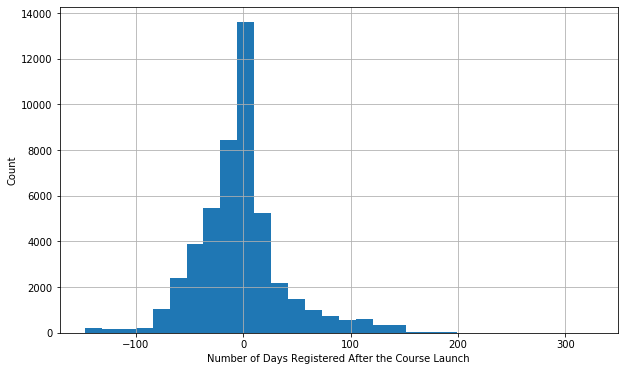

In [40]:
# distribution of registered_launch_delta
plt.figure(figsize=(10,6))
df['registered_launch_delta'].hist(bins=30)
plt.xlabel('Number of Days Registered After the Course Launch')
plt.ylabel('Count')
plt.show()

The distribution is normal distribution, the peak appears around 0.

Most learners registered near the course launch, some learners registered more than 3 months before the course launch, while some registered 10 months after the course launch.

### lifetime_proportion

In [41]:
# statistical description
df.lifetime_proportion.describe()

count    48278.000000
mean        89.307247
std         59.204980
min         13.013699
25%         38.775510
50%         88.785047
75%        115.753425
max        339.795918
Name: lifetime_proportion, dtype: float64

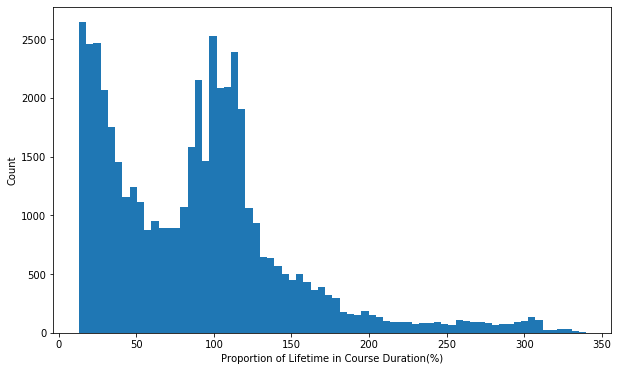

In [42]:
# distribution of lifetime_proportion
plt.figure(figsize=(10, 6))
df.lifetime_proportion.hist(bins=70, grid=False)
plt.xlabel('Proportion of Lifetime in Course Duration(%)')
plt.ylabel('Count')
plt.show()

The distribution has two peaks. One at around 13%, the other at around 100%.

### chapters_proportion

In [43]:
# statistical decsription
df.chapters_proportion.describe()

count    48278.000000
mean        49.721685
std         30.526096
min         13.636364
25%         21.052632
50%         38.235294
75%         81.734007
max        100.000000
Name: chapters_proportion, dtype: float64

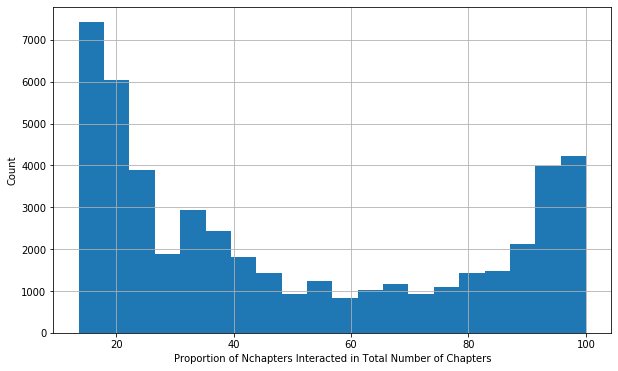

In [44]:
# distribution of chapters_proportion
plt.figure(figsize=(10, 6))
df.chapters_proportion.hist(bins=20)
plt.xlabel('Proportion of Nchapters Interacted in Total Number of Chapters')
plt.ylabel('Count')
plt.show()

Many learners have a proportion less than 20%, half of the learners have a proportion less than 38%.

### Discussion


**Our findings are:**

- course_id: The proportion of intended varies from course. Ranges from 1.26% to 21.69% with a mean of 13.51. The proportion of intended is less than 16.93% for most courses.
- user_id: There are 323419 unique users in the registered dataset, while 44751 users intended to complete the course. Most learners registered in 1 course, some registered in more than one course, the max is 6.
- certified: Among 48278 intended, only 13663 finnaly got certified, the overall certification rate is about 28.30%
- country: Only less than 30% learners are from US. Among those from over seas, a large proportion are from India, only a small portion are from countries like China, Japan.
- education level: The majority of the students have a education level of bachelar's degree or high. Which is to say, we are educating the well educated through MOOCs.
- age: Most learners are in their 20s. Some young learners are as little as 11 years old. While some learners are as old as 78 years old.
- gender: More than 70% of the students are male and only less than 30% are female. 
- grade: Although we defined intended as the grade > 0, the average grade is still as low as 0.31 with a medium grade 0.11. The majority need some more help rather than a small nudge.
- time_registered: The registration trends of registered and intended are similar.
- last_event: Where there is a peak of the last event time of the registered, there is not a significant peak observed for the intended.
- activity variables: The distribution of nevents, ndays_act, nplay_video, nchapters, nforum_posts are all right skewed, many learners have a pretty small number of activities
- institution: More learners intended to complete the course from MITx.
- semester: The proportions of intended among the three semesters are close.
- registered_launch_delta: The distribution is normal distribution, the peak appears around 0.Most learners registered near the course launch, some learners registered more than 3 months before the course launch, while some registered 10 months after the course launch.
- lifetime proportion: The distribution has two peaks. One at around 13%, the other at around 100%.
- chapters_proportion: Many learners have a proportion less than 20%, half of the learners have a proportion less than 38%.

## Bivariate EDA

In this part, we will conduct exploratory analysis on 2 variables. The features of interest in this project are certified and grade. We will try to find out the relationship between other features and these 2 features.

### certification rate by course_id

In [45]:
# certification rate by course
certification_rate_course = 100*(df[df.certified==1].groupby('course_id').certified.count()) / df.groupby('course_id').certified.count()
certification_rate_course


course_id
HarvardX/CB22x/2013_Spring      25.415677
HarvardX/CS50x/2012            100.000000
HarvardX/ER22x/2013_Spring      43.568096
HarvardX/PH207x/2012_Fall       28.730106
HarvardX/PH278x/2013_Spring     25.859247
MITx/14.73x/2013_Spring         41.659292
MITx/2.01x/2013_Spring          22.298222
MITx/3.091x/2012_Fall           36.269015
MITx/3.091x/2013_Spring         27.894737
MITx/6.002x/2012_Fall           31.876889
MITx/6.002x/2013_Spring         27.565982
MITx/6.00x/2012_Fall            18.698335
MITx/6.00x/2013_Spring          12.938151
MITx/7.00x/2013_Spring          26.203209
MITx/8.02x/2013_Spring          20.700000
MITx/8.MReV/2013_Summer         28.650904
Name: certified, dtype: float64

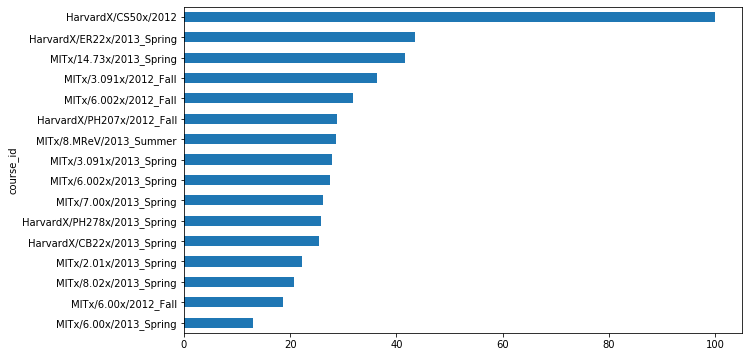

In [46]:
certification_rate_course.sort_values(ascending=True).plot(figsize=(10, 6), kind='barh');

In [47]:
certification_rate_course.describe()

count     16.000000
mean      32.395491
std       19.667316
min       12.938151
25%       24.636313
50%       27.730360
75%       32.974921
max      100.000000
Name: certified, dtype: float64

Certification rate varies a lot. Range from 12.94% to 100% with a mean of 32.40%.

### user_id VS certified

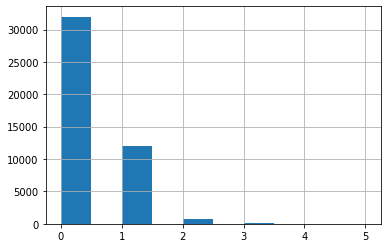

In [48]:
user_certified_df = df.groupby('user_id').certified.sum().reset_index()
user_certified_df.columns = ['user_id', 'ncourse_certified']
user_certified_df.ncourse_certified.hist();

In [49]:
user_certified_df.ncourse_certified.describe()

count    44751.000000
mean         0.305312
std          0.508202
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: ncourse_certified, dtype: float64

In [50]:
user_certified_df.ncourse_certified.value_counts() / user_certified_df.shape[0]

0    0.714532
1    0.268262
2    0.015039
3    0.001832
4    0.000201
5    0.000134
Name: ncourse_certified, dtype: float64

Most learners did not complete any course, around 26.82% learners completed 1 course. Some learners completed as many as 5 courses.

### certification rate by country

In [51]:
certification_rate_country = 100*(df[df.certified==1].groupby('country').certified.count()) / df.groupby('country').certified.count()

certification_rate_country.sort_values(ascending=False)

country
Greece                                    41.360294
France                                    40.203562
Germany                                   39.252336
Spain                                     37.841044
Poland                                    35.672515
Portugal                                  35.658915
Russian Federation                        35.214626
Ukraine                                   33.000000
China                                     32.867133
Other Europe                              32.824253
Other South Asia                          32.566697
Other East Asia                           31.818182
Other North & Central Amer., Caribbean    31.695332
Australia                                 31.150794
United Kingdom                            29.755367
Indonesia                                 28.440367
India                                     28.384687
Colombia                                  27.459954
Other Africa                              26.579836
Cana

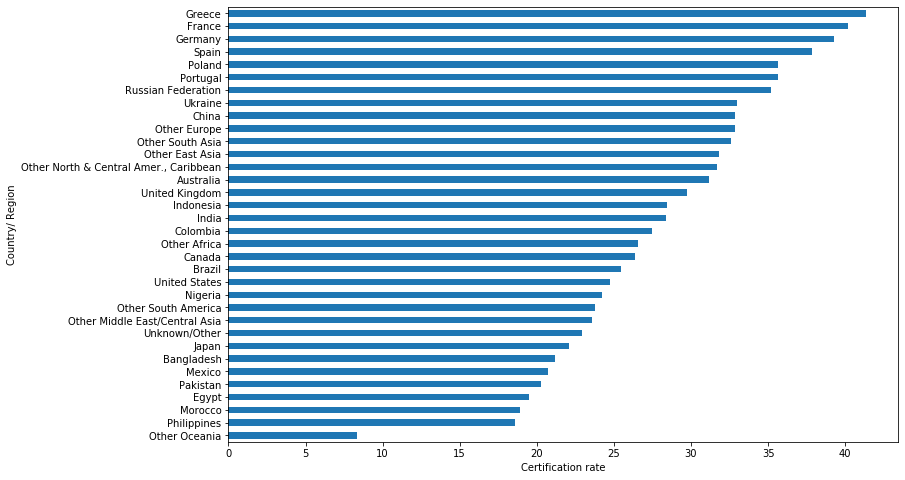

In [52]:
certification_rate_country.sort_values(ascending=True).plot(figsize = (12,8), kind='barh')
plt.xlabel('Certification rate')
plt.ylabel('Country/ Region');

In [53]:
certification_rate_country.describe()

count    34.000000
mean     28.008825
std       7.344904
min       8.333333
25%      23.089357
50%      27.922321
75%      32.856413
max      41.360294
Name: certified, dtype: float64

In [54]:
# chi square test

chisquare(certification_rate_country)

Power_divergenceResult(statistic=63.56109037470136, pvalue=0.0010867078613498178)

The certification rate by country/region varies from 8.33% to 41.36%, with a mean of 28.00% and a medium of 3.38%. The countries with relatively high certification rate are all from Europe. 

### certification rate by level of education

In [55]:
certification_rate_edu = 100*(df[df.certified==1].groupby('education').certified.count()) / df.groupby('education').certified.count()

certification_rate_edu.sort_values(ascending=False)

education
Master's               33.687858
Doctorate              29.257951
Less than Secondary    28.879310
Bachelor's             26.315789
Secondary              26.084591
Name: certified, dtype: float64

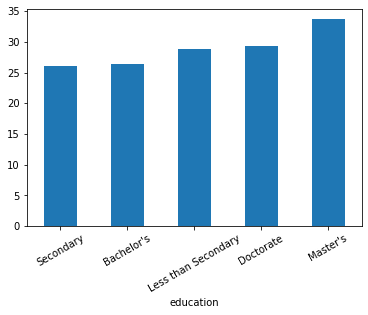

In [56]:
certification_rate_edu.sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation=30);

In [57]:
# chi square test 
chisquare(certification_rate_edu)

Power_divergenceResult(statistic=1.304961211837629, pvalue=0.8605332278853479)

### certification VS age

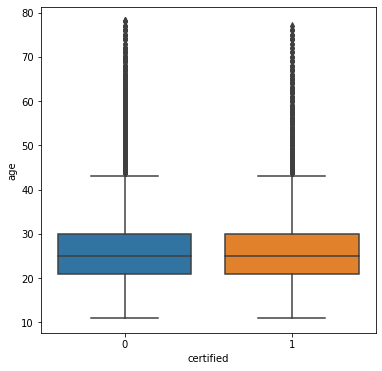

In [58]:
plt.figure(figsize=(6, 6))
sb.boxplot(data=df, x='certified', y='age');

In [59]:
# two samples t test
from scipy.stats import ttest_ind 
ttest_ind(df[df.certified==1].age, df[df.certified==0].age)

Ttest_indResult(statistic=1.3031753928003462, pvalue=0.19252110430299477)

Although the box plot shows no significant difference between age in certified and uncertified. The t test result shows that there is sufficient evidence that the average age of certified is different from uncertified.

### certification rate by gender

In [60]:
certification_rate_gender = 100*(df[df.certified==1].groupby('gender').certified.count()) / df.groupby('gender').certified.count()

certification_rate_gender.sort_values(ascending=False)

gender
f    31.288063
m    27.183996
Name: certified, dtype: float64

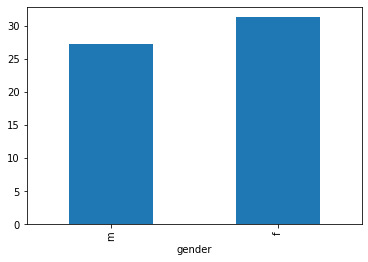

In [61]:
certification_rate_gender.sort_values(ascending=True).plot(kind='bar')

The certification rate of female is almost 4% while of male is juts a little more than 3%.

In [62]:
df[df.certified==1].gender.value_counts()

m    9553
f    4110
Name: gender, dtype: int64

In [63]:
df[df.certified==1].shape

(13663, 25)

In [64]:
# z test
from scipy.stats import binom_test
binom_test(x=9561, n=13673, p=0.5, alternative='greater')

0.0

The p value is very small, there is sufficient evidence that there is more male than female were certified.

### certification VS grade

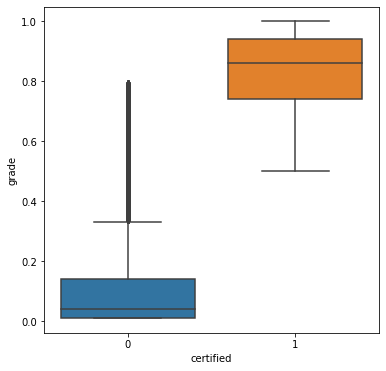

In [65]:
plt.figure(figsize=(6, 6))
sb.boxplot(data=df, x='certified', y='grade');

The average grade of the certified is more than 0.8. The average grade of uncertified is about 0.

### certification VS time_registered

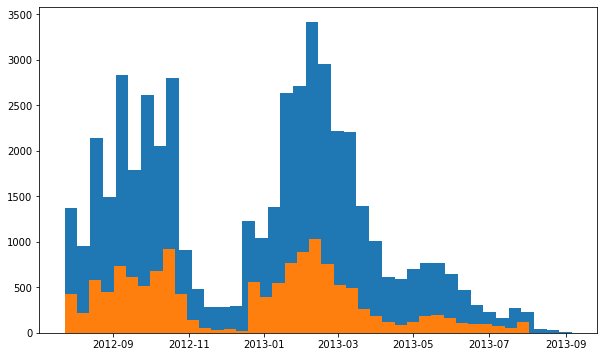

In [66]:
plt.figure(figsize=(10, 6))

plt.hist(data=df, x='time_registered', bins=40)
plt.hist(data=df[df.certified == 1], x='time_registered', bins=40);



The distribution of certified is similar to the distribution of overall enrolment.

### certification VS last event time

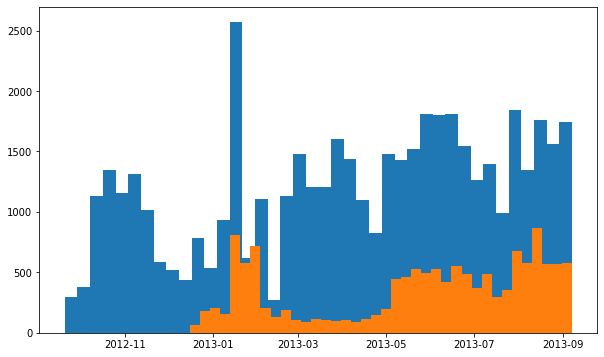

In [67]:
plt.figure(figsize=(10, 6))

plt.hist(data=df, x='last_event', bins=40)
plt.hist(data=df[df.certified == 1], x='last_event', bins=40);

### certification VS activities

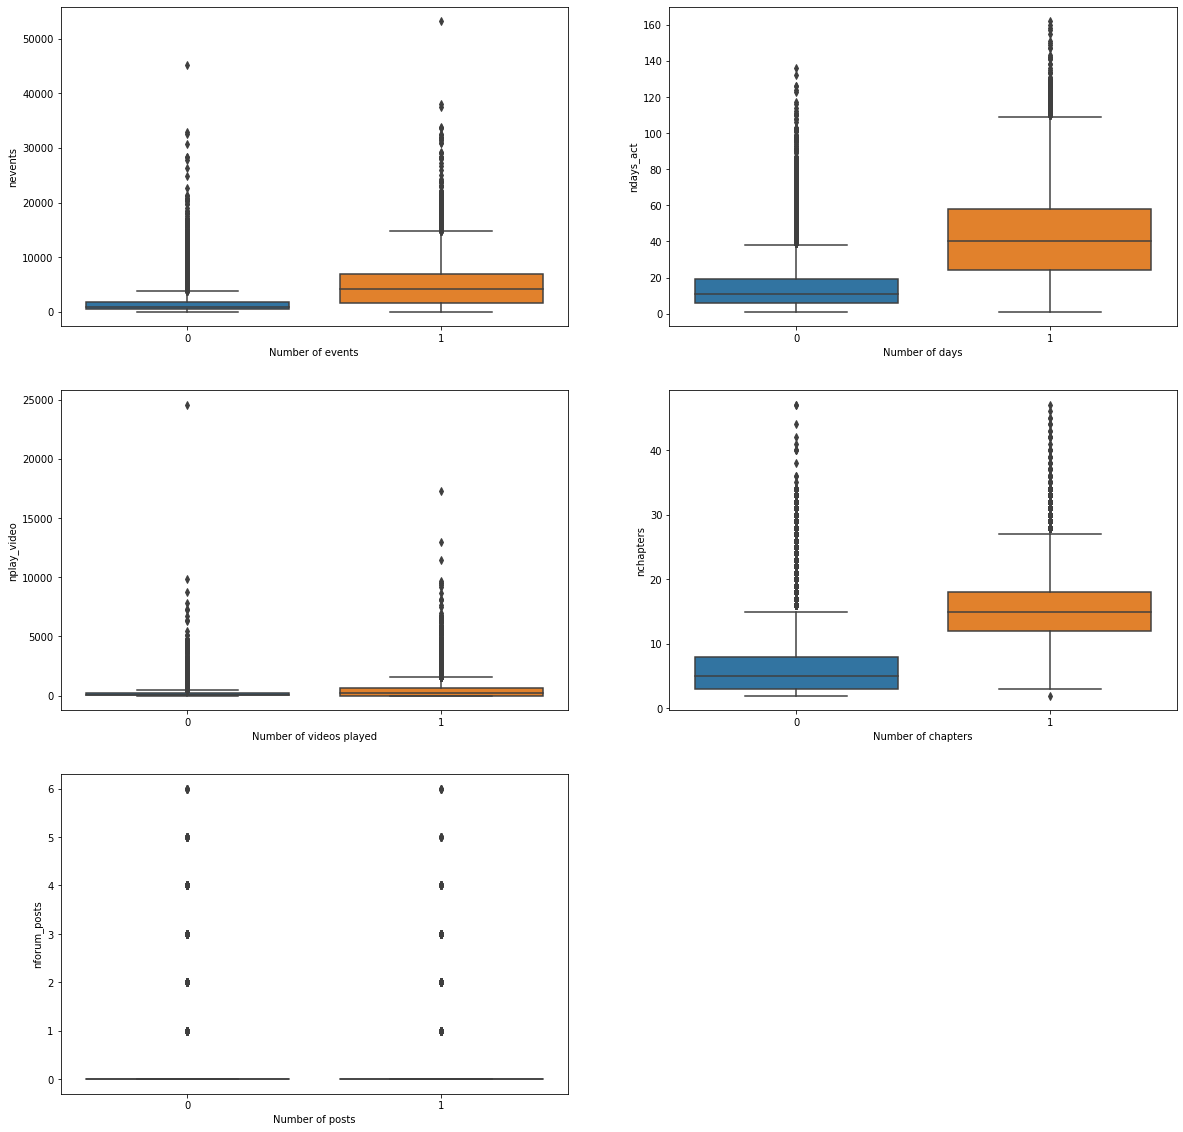

In [68]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 1)
sb.boxplot(data=df, x='certified', y='nevents')
plt.xlabel('Number of events')

plt.subplot(3, 2, 2)
sb.boxplot(data=df, x='certified', y='ndays_act')
plt.xlabel('Number of days')

plt.subplot(3, 2, 3)
sb.boxplot(data=df, x='certified', y='nplay_video')
plt.xlabel('Number of videos played')

plt.subplot(3, 2, 4)
sb.boxplot(data=df, x='certified', y='nchapters')
plt.xlabel('Number of chapters')

plt.subplot(3, 2, 5)
sb.boxplot(data=df, x='certified', y='nforum_posts')
plt.xlabel('Number of posts');

Those certified have more events, more active days , more videos played and more chapters viewed.

The number of posts are pretty small for both certified and uncertified,it is hard to interprete a significant difference. 

### certification rate by instituion

In [69]:
certification_rate_ins = 100*(df[df.certified==1].groupby('institution').certified.count()) / df.groupby('institution').certified.count()

certification_rate_ins.sort_values(ascending=False)

institution
HarvardX    37.300654
MITx        24.125174
Name: certified, dtype: float64

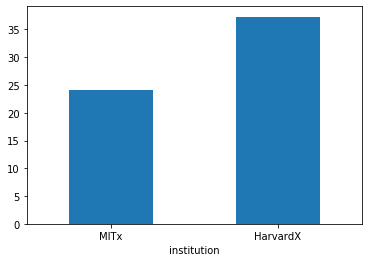

In [70]:
certification_rate_ins.sort_values(ascending=True).plot(kind='bar')
plt.xticks(rotation = 0);

### cetification rate by semester

In [71]:
certification_rate_semester = 100*(df[df.certified==1].groupby('semester').certified.count()) / df.groupby('semester').certified.count()

certification_rate_semester.sort_values(ascending=False)

semester
2012_Fall      29.228451
2013_Summer    28.650904
2013_Spring    27.584290
Name: certified, dtype: float64

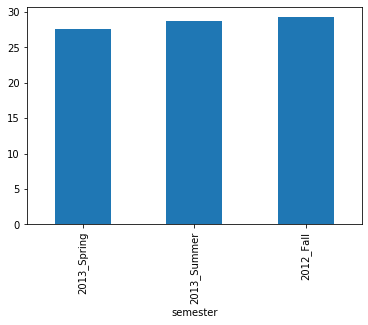

In [72]:
certification_rate_semester.sort_values(ascending=True).plot(kind='bar')

Certification rate of the three semesters are close.

### certification rate VS registered_launch_delta

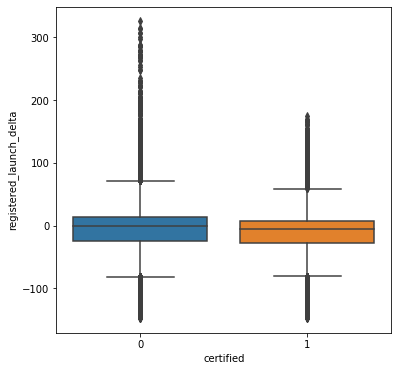

In [73]:
plt.figure(figsize=(6, 6))
sb.boxplot(data=df, x='certified', y='registered_launch_delta');

The average days of registered after course launch is close for certified and uncertified.

### certification VS lifetime proportion

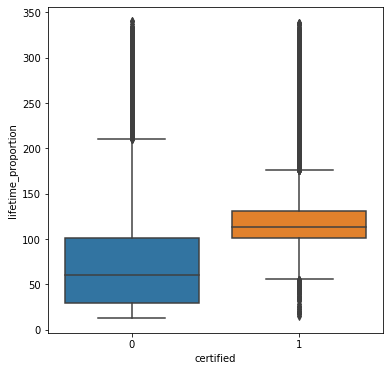

In [74]:
plt.figure(figsize=(6, 6))
sb.boxplot(data=df, x='certified', y='lifetime_proportion');

### grade VS course_id

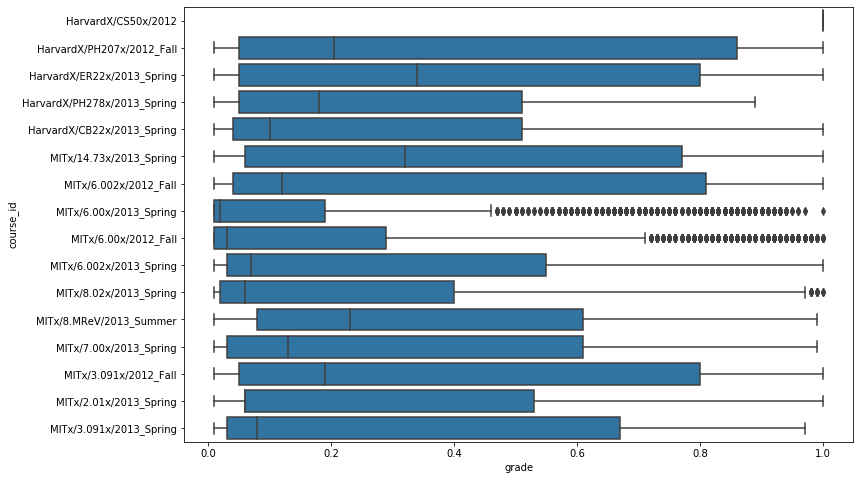

In [75]:
base_color = sb.color_palette()[0]
plt.figure(figsize=(12, 8))
sb.boxplot(data=df, y='course_id', x='grade', orient='h', color=base_color);

### grade VS certified

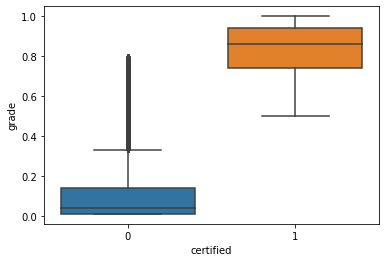

In [76]:
sb.boxplot(data=df, x='certified', y='grade');

### grade VS country

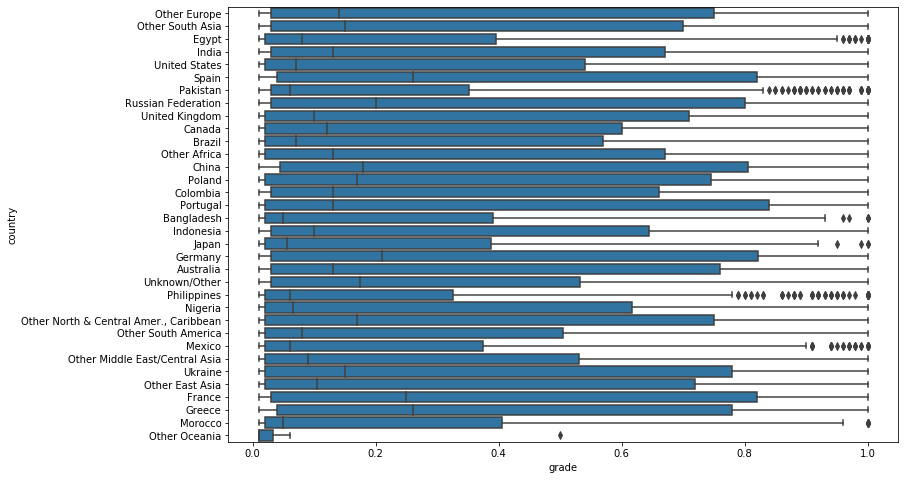

In [77]:
plt.figure(figsize=(12, 8))
base_color = sb.color_palette()[0]
sb.boxplot(data=df, y='country', x='grade', orient='h', color=base_color);

### grade VS education

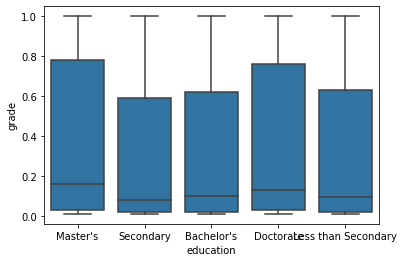

In [78]:
sb.boxplot(data=df, x='education', y='grade',color=base_color);

### grade VS age

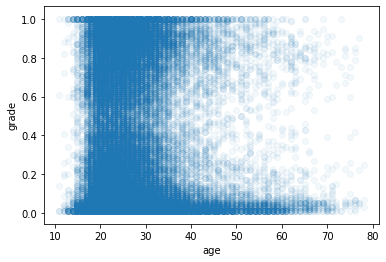

In [79]:
# scatter plot of grade VS age

plt.scatter(data=df, x='age', y='grade',alpha=0.05)
plt.xlabel('age')
plt.ylabel('grade');

It is not a very strong correlation, but we cam still see that as age increase, the likelihood of getting a higher grade drops. students of age 20-30 are more likely to get a higher grade, while it is less likely for older age.

### grade VS gender

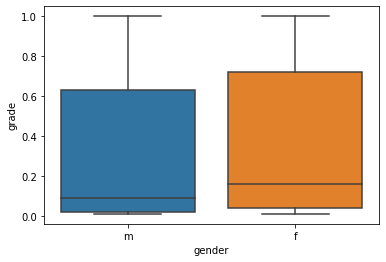

In [80]:
sb.boxplot(data=df, x='gender', y='grade');

### grade VS activities

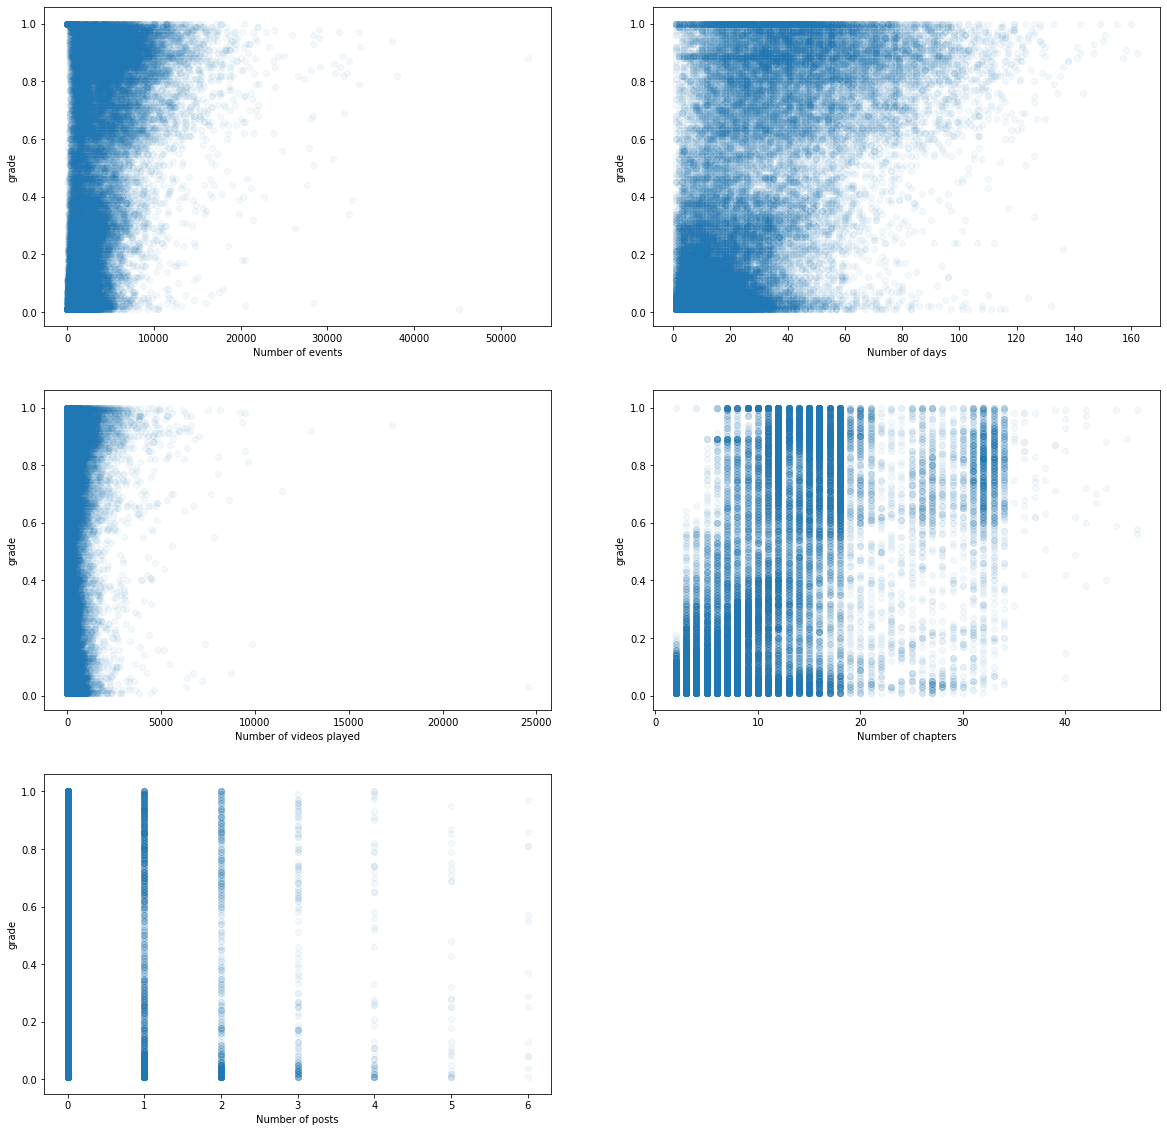

In [81]:
# scatter plot of grade VS activities
plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 1)
plt.scatter(data=df, x='nevents', y='grade', alpha=0.05)
plt.ylabel('grade')
plt.xlabel('Number of events')

plt.subplot(3, 2, 2)
plt.scatter(data=df, x='ndays_act', y='grade', alpha=0.05)
plt.ylabel('grade')
plt.xlabel('Number of days')

plt.subplot(3, 2, 3)
plt.scatter(data=df, x='nplay_video', y='grade', alpha=0.05)
plt.ylabel('grade')
plt.xlabel('Number of videos played')

plt.subplot(3, 2, 4)
plt.scatter(data=df, x='nchapters', y='grade', alpha=0.05)
plt.ylabel('grade')
plt.xlabel('Number of chapters')

plt.subplot(3, 2, 5)
plt.scatter(data=df, x='nforum_posts', y='grade', alpha=0.05)
plt.ylabel('grade')
plt.xlabel('Number of posts');

The more events, active days, chapters, the higher the grade

### grade VS institution

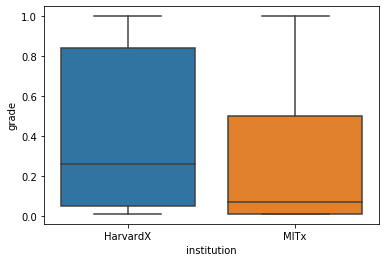

In [82]:
sb.boxplot(data=df, x='institution', y='grade');

### grade VS course name

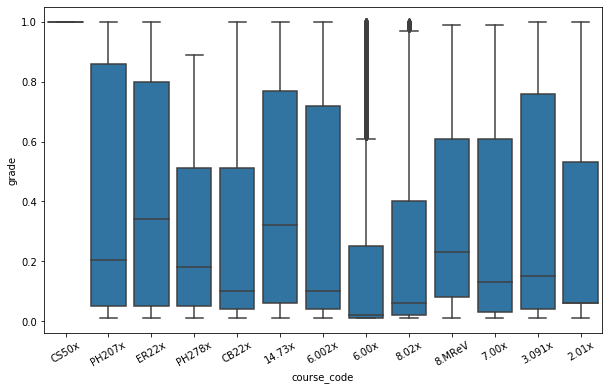

In [83]:
plt.figure(figsize=(10, 6))
sb.boxplot(data=df, x='course_code', y='grade',color=base_color)
plt.xticks(rotation=30);

### grade VS semester

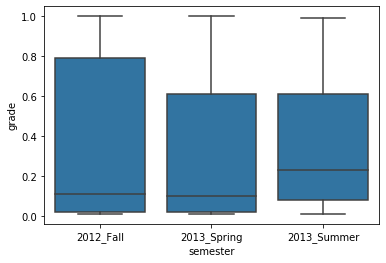

In [84]:
sb.boxplot(data=df, x='semester', y='grade', color=base_color);

### grade VS course launch date

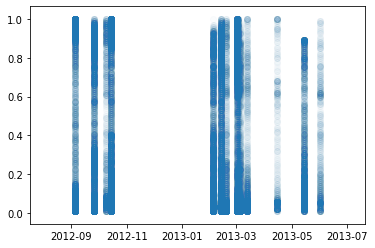

In [85]:
plt.scatter(data=df, x='course_launch', y='grade', alpha=0.02);

### grade VS course wrap date

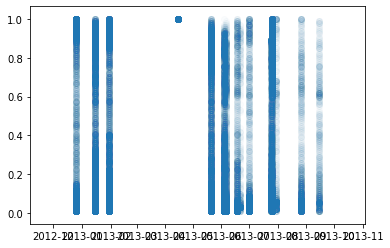

In [86]:
plt.scatter(data=df, x='course_wrap', y='grade', alpha=0.02);

### grade VS course duration

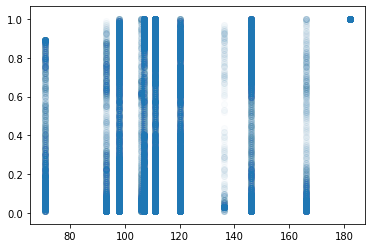

In [87]:
plt.scatter(data=df, x='course_duration', y='grade', alpha=0.02);

### grade VS enrol registered_launch_delta

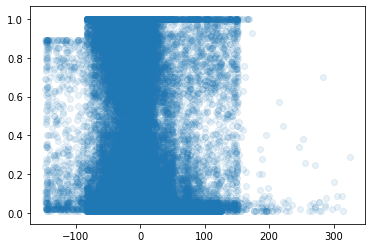

In [88]:
plt.scatter(data=df, x='registered_launch_delta', y ='grade', alpha=0.1);

### grade VS lifetime proportion

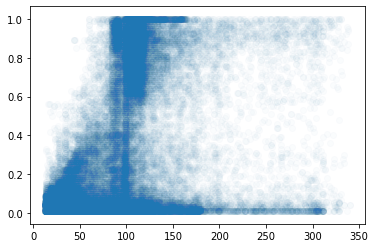

In [89]:
plt.scatter(data=df, x='lifetime_proportion', y='grade', alpha=0.02);

The higher grades appear around lifetime proportiono of 100%. Although there are some outliers that the proportion is more than 100%. Their grades are not higher than grades of proportion around 100%.

### Discussion

- For the 16 courses, the certification rate ranges from 1.25% to 9.04%, with a mean of 3.80% and a median of 3.55%.
- The certification rate of viewed is about 6%. This is higher than the overall certification rate, but it is still very low.
- The certification rate of explored is about 45%.
- The certification rate by country/region varies from 0.11% to 9.97%, with a mean of 3.95% and a medium of 3.38%. The countries with relatively high certification rate are all from Europe.
- Master's has the highest certification rate. While Bachelor's has the lowest certification rate.
- There is no significant difference between age in certified and uncertified.
- The certification rate of female is almost 4% while of male is juts a little more than 3%.
- The average grade of the certified is more than 0.8. The average grade of uncertified is about 0.
- Those certified have more events, more active days , more videos played and more chapters viewed.The number of posts are pretty small for both certified and uncertified,it is hard to interprete a significant difference.
- Certification rate of those who took HarvardX courses is less than 3%. The number is about 4% for those who took MITx courses.
- Later semester tends to have a higher certification rate.
- The median course duration of certified is less than uncertified.
- The completion rate of those who enroled before course launch is around 4%, a little bigger than the certification rate of those who enrol after the course launch, which is about 3%.
- Most of the courses have a grade near 0. The course 'MITx/14.73x/2013_Spring' has a higher grade
- For those explored, the median is grade is about 0.5
- The grade of certified varies from 0.5 to 1, with a median of 0.9
- It is not a very strong correlation, but we cam still see that as age increase, the likelihood of getting a higher grade drops. students of age 20-30 are more likely to get a higher grade, while it is less likely for older age.
- The more events, active days, chapters, the higher the grade. Number of videos and posts  does not significantly impact thee grade.
- The higher grades appear around lifetime proportiono of 100%. Although there are some outliers that the proportion is more than 100%. Their grades are not higher than grades of proportion around 100%.

## Multivariate EDA


In this part we do exploratory analysis on multiple variables.

### grade VS education VS certified

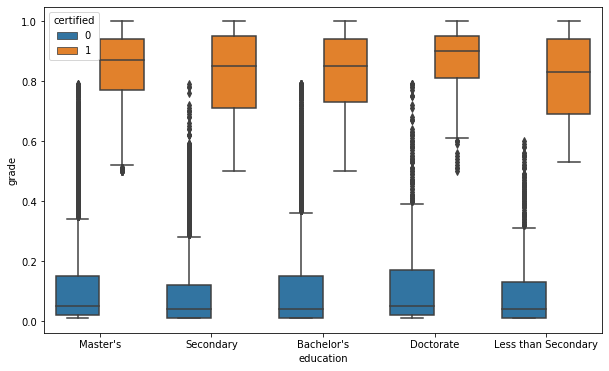

In [90]:
# grade VS Education VS certified
plt.figure(figsize=(10, 6))
sb.boxplot(data=df, x='education', y='grade', hue='certified');

Median grades for uncertified is about 0. For certified are above 0.8. Doctorate has the highest median grade.

### age VS education level VS certified

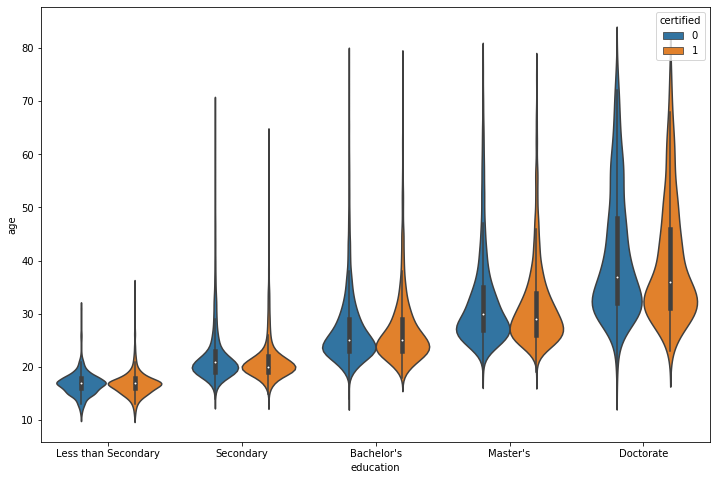

In [91]:
# Violin plot of age distribution by certified, by education level
plt.figure(figsize=(12, 8))
order = ['Less than Secondary','Secondary', "Bachelor's", "Master's", 'Doctorate']
sb.violinplot(data=df, x='education', y='age', hue='certified', order=order);

For those who have a Master's or Doctorate Degree, the median age of the certified is less than uncertified. 

### gender VS lifetime_proportion VS certified

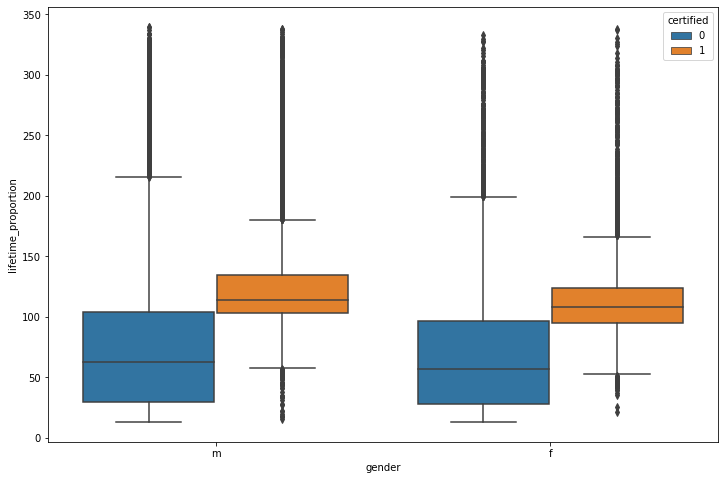

In [92]:
plt.figure(figsize=(12, 8))
sb.boxplot(data=df, x='gender', y='lifetime_proportion', hue='certified');

### lifetime_proportion VS grade VS gender

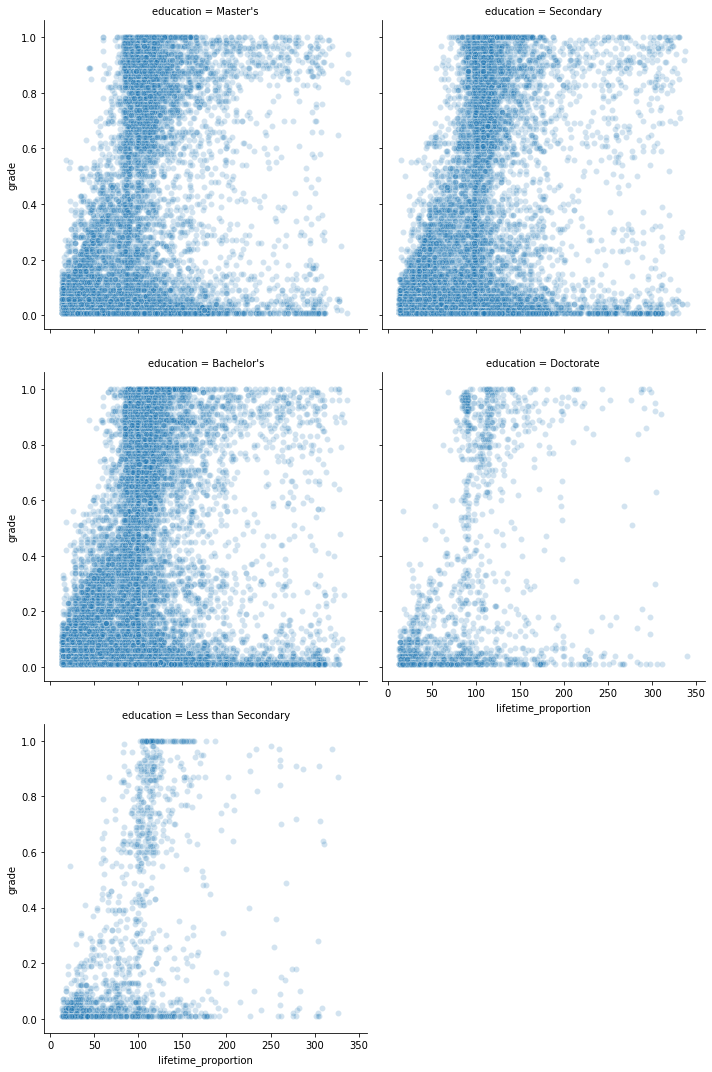

In [93]:
sb.relplot(data=df, x='lifetime_proportion', y='grade', alpha= 0.2, col='education', col_wrap=2);

In [94]:
df.semester.unique()

array(['2012_Fall', '2013_Spring', '2013_Summer'], dtype=object)

### user_id VS certified VS semester

For those who had completed one course, are they more likely to complete a subsequent course? 

We will first select the users who completed at least one course in the 2012_Fall semester. Then we will look at the certification rate of those who registered in the 2013_Spring semester among those who completed a course in the 2012_Fall semester. We will also look at the overall certification rate of 2013_Spring semester for comparation.

In [95]:
# learners who completed at least one course in the 2012_Fall semester.
user_list = df[(df.semester == '2012_Fall') & (df.certified == 1)].user_id.unique()
user_list

array(['MHxPC130320562', 'MHxPC130574671', 'MHxPC130158860', ...,
       'MHxPC130579710', 'MHxPC130330256', 'MHxPC130358119'], dtype=object)

In [96]:
# 2013 Spring semester certification rate for learners who completed at least one course in the 2012_Fall semester.
df_2013_spring = df[df.semester == '2013_Spring']
df_2013_spring[df_2013_spring.user_id.isin(user_list)].certified.value_counts()


0    311
1    286
Name: certified, dtype: int64

In [97]:
certification_rate1 = df_2013_spring[df_2013_spring.user_id.isin(user_list)].certified.value_counts()[1]/df_2013_spring[df_2013_spring.user_id.isin(user_list)].shape[0]
print('The 2013 Spring semester certification rate for learners who completed at least one course in the 2012_Fall semester is {:.2%}'.format(certification_rate1))



The 2013 Spring semester certification rate for learners who completed at least one course in the 2012_Fall semester is 47.91%


In [98]:
df_2013_spring.certified.value_counts()

0    19545
1     7445
Name: certified, dtype: int64

In [99]:
# 2013 Spring semester certification rate for all the learners
certification_rate2 = df_2013_spring[df_2013_spring.certified == 1].shape[0] / df_2013_spring.shape[0]
print('2013 Spring semester certification rate for all the learners is {:.2%}'.format(certification_rate2))

2013 Spring semester certification rate for all the learners is 27.58%


In [100]:
# chi square test
chisquare([286, 311], f_exp=[7445, 19545])

Power_divergenceResult(statistic=25811.93533384841, pvalue=0.0)

The p value is 0, there is sufficient evidence that these two certificatio rates are different. 

## Reference

- [pd.to_datetime](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)
- [How to print a percentage value in python?](https://stackoverflow.com/questions/5306756/how-to-print-a-percentage-value-in-python)

- [pandas - add new column to dataframe from dictionary [duplicate]](https://stackoverflow.com/questions/29794959/pandas-add-new-column-to-dataframe-from-dictionary)
- [Python | Convert two lists into a dictionary](https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/)
- [scipy.stats.chisquare](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html)
- [scipy.stats.binom_test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom_test.html)